In [ ]:
# |default_exp execution

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from stringdale.core import  checkLogs
import pytest

In [ ]:
#| export
from copy import deepcopy,copy
import itertools
import logging
import uuid
import sys
import asyncio
from deepmerge import always_merger

from collections import defaultdict,OrderedDict
from contextlib import ExitStack
from pprint import pprint
from pydantic import BaseModel,Field,ConfigDict

from typing import Optional,Union,List,Dict,Any,Literal,Callable
from fastcore.basics import patch
import logging

from stringdale.core import wrap_exception, NamedLambda, maybe_await
from stringdale.mappings import (
    parse_edge_descriptor,
    multi_map,
    assert_keys_contiguous,
    access,
    map_object,
    object_to_args_kwargs,
)
from stringdale.base import (
    DiagramSchema,Diagram,BaseModelExtra,DiagramType
    ,_is_attr_method,get_state_key,set_state_key)

from stringdale.declerative import Define,Scope,V,E



In [ ]:
#| export
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
#| export
logger = logging.getLogger(__name__)

# Example schemas

In [ ]:
from time import sleep

In [ ]:
def plus1(x):
    return x+1

def plus2(x):
    return x+2

def mod2(x):
    return x%2==0


def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

def is_b_even(obj):
    return obj['b']%2==0

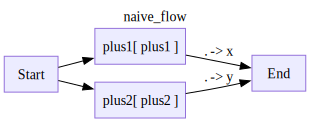

In [ ]:
with Define('naive_flow',type='flow') as NaiveFlow:

    V('plus1',plus1,inputs=['Start'],outputs=['End(x=.)'])
    V('plus2',plus2,inputs=['Start'],outputs=['End(y=.)'])
    

NaiveFlow.draw(direction='LR')

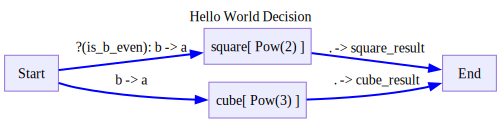

In [ ]:
with Define('Hello World Decision',type='decision') as NaiveDecision:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

NaiveDecision.draw(direction='LR')

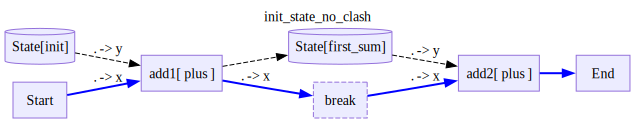

In [ ]:
def plus(x,y):
    return x+y

with Define('init_state_no_clash',type='decision') as WithState:
    
    V('add1',plus,
        inputs=['Start(x)','State/init(y)'],
        outputs=['State/first_sum']
        )

    V('break',is_break=True,inputs=['add1(x)'])

    V('add2',plus,
        inputs=['break(x)','State/first_sum(y)'],
        outputs=['End']
        )

WithState.draw(direction='LR')

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

class Add():
    def __init__(self,a):
        self.a = a
    def __call__(self,b):
        return self.a+b
    def __str__(self):
        return f'Add({self.a})'

class IsModulo():
    def __init__(self,mod):
        self.mod = mod
    def __call__(self,a):
        return a%self.mod==0
    def __str__(self):
        return f'IsModulo({self.mod})'

class EqualsTo():
    def __init__(self,value):
        self.value = value
    def __call__(self,a):
        return a==self.value
    def __str__(self):
        return f'EqualsTo({self.value})'

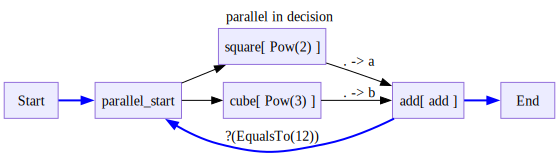

In [ ]:
with Define('parallel in decision',type='decision') as Compound:
    
    V('parallel_start',inputs=['Start'])
    
    # all edges defined within a flow scope are automatically added as flow edges
    with Scope('flow'):
        V('square',Pow(2),inputs=['parallel_start'])
        V('cube',Pow(3),inputs=['parallel_start'])
        V('add',add,inputs=['square(a)','cube(b)'])
        # we can override the scope and define an edge type explicitly
        E('add->parallel_start',cond=EqualsTo(12),type='decision')
    
    E('add->End')

Compound.draw(direction='LR')

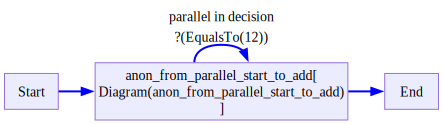

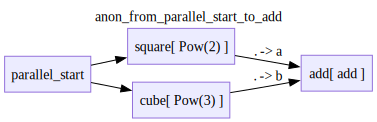

In [ ]:
Compound.draw(direction='LR',factored=True)

# Accessing state

In [ ]:
#| export

@patch
def get_state(self:Diagram,key):
    state = self.get_root().state
    return get_state_key(state,key)

@patch
def set_state(self:Diagram,key,value):
    state = self.get_root().state
    set_state_key(state,key,value)


def simplify_output(input_):
    if isinstance(input_,dict) and len(input_) ==1 and 0 in input_:
        output = input_[0]
    else:
        output = input_ 
    return output

In [ ]:
d = WithState()
assert d['add1'] == d['add2']
assert d['add1'] == plus

d.set_state('first_sum',1)
assert d.get_state('first_sum')==1

# d.draw()

In [ ]:
d = Compound()
d['cube'] = Pow(4)
assert d['cube'].__class__ == Pow 
assert d['cube'].power == 4

In [ ]:
#| export

@patch
def _set_node_output(self:Diagram, node, output):
    # for each write state, get the output at the port position and set it to the state at based on the key
    graph = self.graph
    for key,mapping in graph.nodes[node].get('write_state',{}).items():      
        object_to_write = simplify_output(map_object(output,mapping))
        logger.debug(f"Setting state '{key}' based on output {output}\n"
                    f"after mapping it to {object_to_write}\n"
                    f"with mapping {mapping}")
        self.set_state(key,object_to_write)



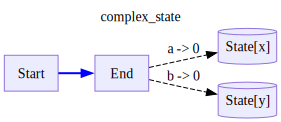

__main__ - DEBUG - Setting state 'x' based on output {'a': 1, 'b': 2, 'c': 3}
after mapping it to 1
with mapping {0: ('a',)}
__main__ - DEBUG - Setting state 'y' based on output {'a': 1, 'b': 2, 'c': 3}
after mapping it to 2
with mapping {0: ('b',)}


In [ ]:
with Define('complex_state',type='decision') as D:
    V('End',inputs=['Start'],
    outputs = [
        'state/x(0=a)',
        'state/y(0=b)'
        ])
D.draw()

d=D()
with checkLogs():
    d._set_node_output('End',{'a':1,'b':2,'c':3})
assert d.state.model_dump() == {'x':1,'y':2}

In [ ]:
#|export

@patch
def _get_state_input_keys(self:Diagram,node):
    return list(self.graph.nodes[node].get('read_state',{}).keys())
@patch
def _get_state_input(self:Diagram,node):
    keys = self._get_state_input_keys(node)
    return {('state',key):simplify_output(self.get_state(key)) for key in keys}

@patch
@wrap_exception("Error computing node input for node {{node}} for diagram {{name}}")
def compute_node_input(self:Diagram,node,previous_outputs,state,raw_input=False,partial=False):
    """Prepare the input for the next node execution"""
    name = self.name
    graph = self.graph
    logger.debug(f"diagram {self.name} preparing input for node '{node}' based on previous outputs {previous_outputs}")

    port_mappings = graph.nodes[node].get('mapping',{})
    state_objects = self._get_state_input(node)

    if raw_input:
        object_to_map = state_objects
    else:
        object_to_map = previous_outputs | state_objects

    func_input = multi_map(object_to_map,port_mappings)

    if raw_input:
        if isinstance(previous_outputs,dict):
            func_input = previous_outputs|func_input
        else:
            func_input = {0:simplify_output(previous_outputs)}|func_input

    logger.debug(f"diagram {self.name} for node '{node}' input prepared:{func_input}")

    return func_input


In [ ]:
#| export
@patch

def _before_node(self:Diagram,node,input_):
    # if we got a validator, validate the input
    self._validate_node_input(node,input_)
    
    return self[node]

@patch
def _after_node(self:Diagram,node,output):
    self._validate_node_output(node,output)
    # set the output to the outbound state
    self._set_node_output(node,output)
    return 

@patch
def _validate_node_input(self:Diagram,node,func_input):
    # get the input validator
    # if validator is basemodel, and there is only a singel arg, validate it
    # if validator is basemodel, and there are only kwargs, validate them as a dict
    # if validator is basemodel, and there are args and kwargs, log a warning

    # if validator is callable, run it on input as args and kwargs
    return 

@patch
def _validate_node_output(self:Diagram,node,output):
    # get the output validator
    # if validator is basemodel validate it against it
    # if validator is callable, run it on output as a single arg
    return 

# Traces

In [ ]:
#| export
from datetime import datetime,timedelta
from typing import Optional
from pydantic import BaseModel, computed_field
from pprint import pprint
from typing import Dict,Any,Literal,Union,List
import os
from pprint import pformat
from textwrap import indent
from pathlib import Path
from pprint import PrettyPrinter
import yaml
from collections import OrderedDict
import yaml
from typing import Iterator, Any
import textwrap

In [ ]:
#| export

class LongStringSafeYAMLDumper(yaml.SafeDumper):
    """Custom YAML dumper that handles long strings intelligently"""
    
    width = 80
    max_lines = 10

    def __init__(self, *args, width=80, max_lines = 10, **kwargs):
        super().__init__(*args, **kwargs)
        
    def get_item_length(self, item):
        """Calculate the string representation length of an item"""
        if isinstance(item, str):
            return max(len(line) for line in item.split('\n'))
        elif isinstance(item, (list, dict)):
            # For nested structures, dump to string and get max line length
            dumped = yaml.dump(item, Dumper=yaml.SafeDumper)
            return len(dumped)
        else:
            return len(str(item))
    def represent_list(self, data):
        # Check max length of any item in the list
        max_item_length = max(self.get_item_length(item) for item in data)
        
        # Use flow style only if the longest item fits within width
        # Add some padding for brackets and commas
        use_flow = max_item_length + 4 < self.width
        
        return self.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=use_flow)


    def represent_str(self, data):
        # Count lines if string was wrapped
        wrapped_lines = len(textwrap.wrap(data, width=self.width))
        actual_lines = data.count('\n') + 1
        total_lines = max(wrapped_lines, actual_lines)
        if total_lines < self.max_lines and total_lines > 2:
            # Use literal block style (|) for multiline strings
            warpped_data = '\n'.join(textwrap.wrap(data,width=self.width))
            return self.represent_scalar('tag:yaml.org,2002:str', warpped_data, style='|')
        elif total_lines > self.max_lines:
            explicit_newlines_data = data.replace('\n', '\\n')
            return self.represent_scalar('tag:yaml.org,2002:str', explicit_newlines_data, style='|')
            # return self.represent_scalar('tag:yaml.org,2002:str', explicit_newlines_data)
        else:
            return self.represent_scalar('tag:yaml.org,2002:str', data)
            # Use default style for shorter strings

    
    def represent_unknown(self, data):
        """Default representer for unknown types - converts to string"""
        return self.represent_scalar('tag:yaml.org,2002:str', str(data))
    
    def ignore_aliases(self, data):
            return True


def pformat_yaml(data: Any, width: int = 80,max_lines: int = 10):
    """
    Stream writes items to a YAML file with smart handling of long strings.
    
    Args:
        file_path: Path to output file
        data_iterator: Iterator/generator that yields YAML-serializable items
        width: Maximum line width for text wrapping calculation
    """

    LongStringSafeYAMLDumper.width = width
    LongStringSafeYAMLDumper.max_lines = max_lines
    LongStringSafeYAMLDumper.add_representer(str, LongStringSafeYAMLDumper.represent_str)
    LongStringSafeYAMLDumper.add_representer(OrderedDict, LongStringSafeYAMLDumper.represent_dict)
    LongStringSafeYAMLDumper.add_representer(list, LongStringSafeYAMLDumper.represent_list)
    LongStringSafeYAMLDumper.add_multi_representer(object, LongStringSafeYAMLDumper.represent_unknown)

    return yaml.dump(data,Dumper=LongStringSafeYAMLDumper,default_flow_style=False,width=width,sort_keys=False)

In [ ]:
sample_data = {
    "step": "user_query",
    "short_text": "What is the capital of France?",
    "long_text": """This is a much longer piece of text that spans multiple lines and contains detailed information about something important. It might be a log entry or some other kind of detailed output that we want to format nicely in our YAML file.""",
    "too_long_text": """This is a much longer piece of text that spans multiple lines and contains detailed information about something important. It might be a log entry or some other kind of detailed output that we want to format nicely in our YAML file. This is a much longer piece of text that spans multiple lines and contains detailed information about something important. It might be a log entry or some other kind of detailed output that we want to format nicely in our YAML file.""",
    "metadata": {
        "timestamp": "2024-03-21T10:30:00Z",
        "session_id": "abc123" ,
    },
    "list_of_small_items": [
        "item1",
        "item2",
        "item3",
        "item4",
        "item5",
    ],
    "list_of_large_items": [
        {"a":1,"b":2,"c":3,"d":4,"e":5,"f":6,"g":7,"h":8,"i":9,"j":10},
        {"a":'b'*120},
        
    ]

}

res = pformat_yaml(sample_data,max_lines=4)
print(res)

# yaml_path = Path('test.log.yaml')
# yaml_path.write_text(res)
# !cat test.log.yaml
# os.unlink(yaml_path)

step: user_query
short_text: What is the capital of France?
long_text: |-
  This is a much longer piece of text that spans multiple lines and contains
  detailed information about something important. It might be a log entry or some
  other kind of detailed output that we want to format nicely in our YAML file.
too_long_text: |-
  This is a much longer piece of text that spans multiple lines and contains detailed information about something important. It might be a log entry or some other kind of detailed output that we want to format nicely in our YAML file. This is a much longer piece of text that spans multiple lines and contains detailed information about something important. It might be a log entry or some other kind of detailed output that we want to format nicely in our YAML file.
metadata:
  timestamp: '2024-03-21T10:30:00Z'
  session_id: abc123
list_of_small_items: [item1, item2, item3, item4, item5]
list_of_large_items:
- a: 1
  b: 2
  c: 3
  d: 4
  e: 5
  f: 6
  g: 7
  h: 8


In [ ]:
#| export
from stringdale.doc import pprint_yaml
from stringdale.viz import is_ipython

In [ ]:
#| export
class Trace(BaseModel):
    model_config = {"arbitrary_types_allowed": True}
    run_uid: str
    node_uid: str
    node_name: List[str]
    input_idx: List[Union[int,None]] = [None]
    node_func: Optional[Any] = Field(default=None,exclude=True)
    input_state_keys: Optional[set[str]] = None
    input_: Any
    output: Optional[Any] = None
    run_type: DiagramType
    start_time: Optional[datetime] = None
    end_time: Optional[datetime] = None

    @computed_field
    def name(self) -> str:
        return self.pretty_name()

    @computed_field
    def duration(self) -> Optional[timedelta]:
        """Return the duration of the node execution in seconds"""
        if self.start_time is None or self.end_time is None:
            return None
        return (self.end_time - self.start_time)

    def nest(self,name,idx):
        self.node_name.insert(0,name)
        self.input_idx.insert(0,idx)

    def pretty_name(self):
        name_parts = []
        for name,idx in zip(self.node_name,self.input_idx):
            if idx is None:
                name_parts.append(name)
            else:
                name_parts.append(f"{name}[{idx}]")
        return '.'.join(name_parts)

    def pformat(self,add_keys=None,drop_keys=None,extra_keys=None,width=80,str_max_lines=10):

        data = {
            "name":self.name,
            "input":self.input_,
            "output":self.output,
        }

        if add_keys is not None:
            for key in add_keys:
                data[key] = getattr(self,key)
        if drop_keys is not None:
            for key in drop_keys:
                data.pop(key,None)
        if extra_keys is not None:
            data.update(extra_keys)

        return pformat_yaml(data,width=width,max_lines=str_max_lines)

    def write(self,string,file=None):
        if file is None:
            fptr = sys.stdout
        else:
            fptr = open(file,'a')
        fptr.write(string)
        if file is not None:
            fptr.close()

    def pprint(self,
        add_keys=None,
        drop_keys=None,
        extra_keys=None,
        width=80,
        str_max_lines=10,
        skip_passthrough=False,
        file=None):
        """
        Pretty prints the trace information in YAML format.

        The output includes the node name followed by a YAML representation of the trace data.
        By default, it shows the node name, input, output, and duration. The output format
        handles long strings intelligently by using YAML block literals for multiline content.

        Args:
            add_keys (dict, optional): Additional key-value pairs to include in the output.
            drop_keys (list, optional): Keys to exclude from the output.
            extra_keys (dict, optional): Additional key-value pairs to append after standard fields.
            width (int, default=80): Maximum line width for text wrapping.
            str_max_lines (int, default=10): Maximum number of lines to show for string values
                before switching to inline format with explicit newlines.
            skip_passthrough (bool, default=False): If True, skips printing traces for passthrough
                nodes (nodes with no function).
            file (str, optional): Path to file for writing output. If None, prints to stdout.

        """
        if skip_passthrough and self.node_func is None:
            return
            
        formatted = self.pformat(add_keys,drop_keys,extra_keys,width,str_max_lines)
        
        if file is None:
            formatted = '---\n' + formatted
            if is_ipython():
                pprint_yaml(formatted,style='native')
            else:
                self.write(formatted)
            
        else:
            if os.path.exists(file) and os.path.getsize(file) > 0:
                formatted = '---\n' + formatted
            self.write(formatted, file=file)


In [ ]:
import math

In [ ]:
t = Trace(
    run_uid = '123',
    node_uid = '456',
    node_name = ['Start'],
    input_idx = [None],
    node_func = math.exp,
    input_state_keys = set(),
    input_ = {'foo':1},
    output = 2,
    run_type = DiagramType.decision,
    start_time = datetime.now(),
    end_time = datetime.now(),
)
t.pprint()

In [ ]:
#| export
@patch
def prep_trace(self:Diagram,node,input_,output,type=DiagramType.decision,idx=None,start_time=None,end_time=None):
    input_state_keys = self.graph.nodes[node].get('read_state',{}).keys()
    return Trace(
        run_uid = self.run_uid,
        node_uid = str(uuid.uuid4()),
        node_name = [node],
        input_idx = [idx],
        node_func = self[node],
        input_state_keys = input_state_keys,
        input_ = input_,
        output = output,
        run_type = type,
        start_time = start_time,
        end_time = end_time
        )


# Running nodes

In [ ]:
#| export

@patch
async def run_node(self:Diagram,node,input_,idx=None):

    graph = self.graph
    
    func = self._before_node(node,input_)

    start_time = datetime.now()

    logger.debug(f"Running node '{node}[{idx}]' with input {input_} and state {self.state}")
    if func is None:
        output = simplify_output(input_)
    else:
        args,kwargs = object_to_args_kwargs(input_)
        try:
            # run the node
            output = await maybe_await(func,args,kwargs)
        except Exception as e:
            raise ValueError(f"When running node '{node}[{idx}]':\n"
                f"Function {func}\n"
                f"args={args}\n"
                f"kwargs={kwargs}\n"
                f"returned Error \n'{e}'\n") from e

    end_time = datetime.now()

    logger.debug(f"{node}({input_})={output}")
    self._after_node(node,output) 
    return input_,output,start_time,end_time


@patch
async def run_subdiagram_iter(self:Diagram,node,input_,subdiagram,idx=None):
    """
    Run a subdiagram as a node
    yields traces from the subdiagram
    returns the output of the subdiagram and the subdiagram itself
    """
    graph = self.graph

    _ = self._before_node(node,input_)

    func = subdiagram

    # run the sub diagram via its run method as an iterator,
    # yield traces from the sub diagram
    start_time = datetime.now()

    async for trace in subdiagram.arun(input_,progress_bars=self.progress_bars):
        # append the name of the node to the last node and nodes with a '.' delimiter
        if not self.trace_nested:
            # if we dont want nested trace print yielding them.
            continue
        if not subdiagram.anon:
            trace.nest(node,idx)
        yield trace

    end_time = datetime.now()

    # after the subdiagram is done, set the output to the outbound state
    self._after_node(node,subdiagram.output)
    subdiagram.start_time = start_time
    subdiagram.end_time = end_time
    return 




# Run Decision Diagrams


In [ ]:
#| export

decision_logger = logging.getLogger(f'{__name__}.decision')

@wrap_exception("Running decision diagram {self.name} with input {input_}, finished: {self.finished}")
@patch
async def arun_decision(self:Diagram,input_,state,**kwargs):

    decision_logger.debug(
        f"Running decision diagram {self.name}@{hex(id(self))}, finished: {self.finished}\n"
        f"\t input: {input_}")
    # print(f"Running decision diagram {self.name} with input {input_}, finished: {self.finished}")
    if self.finished in [True,None]:
        self.finished = False
        current_node = self.start_node
        is_continue = False
    else:
        current_node = self.next_node
        is_continue = True
        

    graph = self.graph
    # no need to map ports on iteration
    raw_input = True

    while True:
        func = self[current_node]
        is_sub_diagram = isinstance(func,Diagram)
        is_anon_sub_diagram = is_sub_diagram and func.anon

        if is_sub_diagram and is_continue:
            # in this case we are continuing from an inner breakpoint, so we send the input from the user straight to the subdiagram.
            decision_logger.debug(f"Continuing to inner breakpoint {current_node} with input {input_}")
            
        else:
            input_ = self.compute_node_input(current_node,input_,self.state,raw_input,partial=True)

        is_continue = False # This can only be true for the first iteration of the loop when continuing from an inner breakpoint

        if is_sub_diagram:
            # subdiagram = copy(func)
            subdiagram = func
            async for trace in self.run_subdiagram_iter(current_node,input_,subdiagram,**kwargs):
                yield trace
            output = subdiagram.output
            start_time = subdiagram.start_time
            end_time = subdiagram.end_time
        else:
            _,output,start_time,end_time = await self.run_node(current_node,input_,**kwargs)
        # TODO the delta time should also work for sub diagrams with breakpoints, for the entire duration until they finished, excluding waiting time to continue.
        
        sub_dir_break = is_sub_diagram and subdiagram.finished == False

        raw_input = False
        if not (is_anon_sub_diagram or sub_dir_break):
            yield self.prep_trace(current_node,input_=input_,output=output,type=DiagramType.decision,start_time=start_time,end_time=end_time)

        if sub_dir_break:
            next_node = current_node
            decision_logger.debug(f"Sub diagram {current_node} is not finished, will continue from it when run again")
        else:
            next_node = self.choose_next_node(current_node,output)
            decision_logger.debug(f"Choosing next node after {current_node} with output {output}: {next_node}")
        
        is_end = next_node is None

        is_break = sub_dir_break or (not is_end and graph.nodes[next_node].get('is_break',False))

        # if we are at the end or a breakpoint,
        # prep for the next run and exit
        if is_end:
            self.finished = True
        if is_end or is_break:
            # set the output as the output of the last node we run
            saved_output = output
            
            self.output = simplify_output(output)
            # set the next node to run
            self.next_node = next_node
            return 
        
        input_ = {current_node:output}
        current_node = next_node

    decision_logger.debug(f"Decision diagram {self.name} finished with output {self.output}")
    # should never get here
    return 


In [ ]:
#| export
@patch
def choose_next_node(self:Diagram,node,output):
    """
    Based on the output of the last node, choose the next node
    returns the next node to run, or None if we are at the end
    """

    graph = self.graph
    if node ==self.end_node:
        return None

    # get a dict with each condition and its target node 
    # and get the default target node
    # based on the outgoing edges from the node

    out_going_edges = {target:data for source,target,data in graph.out_edges(node,data=True)}
    condition_per_target = {}
    for target,data in out_going_edges.items():
        if 'condition' in data:
            condition_per_target[target] = data['condition']
        else:
            default_target = target
    decision_logger.debug(f"Condition per target for node '{node}': {condition_per_target}")
    # run the condition functions of each target node on the output
    condition_results = {}
    for target,condition_func in condition_per_target.items():
        try:
            condition_result = condition_func(output)
        except Exception as e:
            raise ValueError(f"When choosing next node after {node}:\n"
                f"Condition function {condition_func}({output}) returned \n{type(e).__name__}:'{e}'"
                ).with_traceback(e.__traceback__)

        # if any condition function returned something other than a boolean, raise an error
        if not isinstance(condition_result,bool):
            raise ValueError(f"When choosing next node after {node}:\n"
                f"Condition function {condition_func} returned {condition_result} which is not a boolean when evaluated on output {output}")
        condition_results[target] = condition_result

    decision_logger.debug(f"Condition results for node '{node}' with output {output}: {condition_results}")
    # if there are more than 2 trues
        # raise an error
    num_trues = sum(condition_results.values())
    if num_trues > 1:
        raise ValueError(f"When choosing next node after {node}:\n"
            f"More than one condition function succeeded when evaluated on output {output}"
            f"condition results: {condition_results}"
            )
    # if there is one true, return the target node of that condition
    elif num_trues == 1:
        chosen_target = next(target for target,result in condition_results.items() if result)
    # if there are no trues, return the default target
    else:
        chosen_target = default_target
    
    return chosen_target


# Run Flow Diagrams


In [ ]:
#| export
from stringdale.core import (
    new_combinations,
    merge_list_dicts,
    dict_cartesian_product
    )

In [ ]:
#| export

flow_logger = logging.getLogger(f'{__name__}.flow')


async def _wait_for_tasks( tasks):
    """Wait for any task to complete from any of the task dictionaries"""
    all_tasks = (*tasks['regular'],*tasks['iterator'],*tasks['subdiagram'])
    if not all_tasks:
        return None
    done, _ = await asyncio.wait(
        all_tasks,
        return_when=asyncio.FIRST_COMPLETED
    )
    return done


In [ ]:
#| export
import enum

In [ ]:
#| export
def _has_foreach(graph,node):
    return graph.nodes[node].get('for_each',list()) != []

class NodeState(enum.Enum):
    waiting = 0
    running = 1
    finished = 2

@patch
def _did_all_fathers_run(self:Diagram,graph,node):
    fathers = list(graph.predecessors(node))
    flow_logger.debug(f"Checking if all fathers {fathers} for node '{node}' have run at least once. node state: {self.node_state}")
    return all(self.node_state[father] != NodeState.waiting for father in fathers)

@patch
def _did_all_fathers_finish(self:Diagram,graph,node):
    fathers = list(graph.predecessors(node))
    flow_logger.debug(f"Checking if all fathers {fathers} for node '{node}' have finished. node state: {self.node_state}")
    return all(self.node_state[father] == NodeState.finished for father in fathers)

@patch
def _running_node_tasks(self:Diagram,node):
    graph = self.graph
    task_nodes = set()
    for tasks_per_type in self.tasks.values():
        for task in tasks_per_type.values():
            task_nodes.add(task[0])
    return task_nodes


@patch
def can_generate_new_input(self:Diagram,graph,node):
    flow_logger.debug(f"Checking if we can generate new input for node '{node}'. node state: {self.node_state}")
    if _has_foreach(graph,node):
        flow_logger.debug(f"Node '{node}' has foreach, checking if all fathers have run at least once")
        res =  self._did_all_fathers_run(graph,node)
    else:
        flow_logger.debug(f"Node '{node}' does not have foreach, checking if all fathers have finished")
        res = self._did_all_fathers_finish(graph,node)

    flow_logger.debug(f"Node '{node}' can generate new input: {res}")
    return res

@patch
def update_state(self:Diagram,graph,node):
    if self._did_all_fathers_finish(graph,node) and node not in self._running_node_tasks(graph):
        new_state = NodeState.finished
    else:
        new_state = NodeState.running
    flow_logger.debug(f"Updating state for node '{node}'. new state: {new_state}")
    self.node_state[node] = new_state


    # self is running is any of its fathers are still running and it is not a foreach node
    # self is finished if all fathers are finished and it is not a 


In [ ]:
#| export
@patch
def enqueue_task(self:Diagram, node, input_, idx):
    """
    Create appropriate task type and add to corresponding task dict.
    Handles AsyncIter initialization and tracks task creation time.
    
    Args:
        node: Node to execute
        input_: Input data for the node
        idx: Execution index for the node
        tasks: Dict of regular tasks
        iterator_tasks: Dict of iterator tasks
        subdiagram_tasks: Dict of subdiagram tasks
    """
    tasks = self.tasks
    func = self[node]
    creation_time = datetime.now()
    
    if isinstance(func, Diagram):
        # Create subdiagram task
        # copy the subdiagram so that we dont share state between them if they are used multiple times or in foreach
        logger.debug(f'copying diagram {func} with name {func.name}')
        subdiagram = copy(func)
        subdiagram_iter = self.run_subdiagram_iter(node, input_,subdiagram,idx)
        task = asyncio.create_task(subdiagram_iter.__anext__())
        task_info = (node, idx, subdiagram, subdiagram_iter, input_, creation_time)
        tasks['subdiagram'][task] = task_info
        

    else:
        # Create regular task
        task = asyncio.create_task(self.run_node(node, input_,idx))
        task_info = (node, idx, func, None ,input_, creation_time)
        tasks['regular'][task] = task_info

    if isinstance(input_,dict):
        pretty_input_ = input_
    elif isinstance(input_,FunctionInput):
        pretty_input_ = input_.to_positional_kwargs()
    else:
        pretty_input_ = input_
    input_str = ', '.join([f"{k}={v}" for k,v in pretty_input_.items()])
    flow_logger.debug(f"Enqueued {task.get_name()} for {node}[{idx}]({input_str})")
        

In [ ]:
#| export

def _pretty_tasks(tasks):
    pretty_tasks = {}
    for task_type in tasks:
        pretty_tasks[task_type] = {task.get_name():f'{node}[{idx}]({input_})' for task,(node,idx,_,input_,_) in tasks[task_type].items()}
    return pretty_tasks

@patch
def handle_finished_task(self:Diagram, task):
    """Handle a completed task and return node, trace, and outputs
    
    Args:
        task: The completed asyncio task
        
    Returns:
        Tuple of:
        - node: The node that completed
        - trace: The execution trace (or None)
        - outputs: List of outputs (or None)
    """
    trace = None
    
    tasks = self.tasks
    regular_tasks = tasks['regular']
    iterator_tasks = tasks['iterator']
    subdiagram_tasks = tasks['subdiagram']

    process_output = False

    # Handle regular task
    if task in regular_tasks:
        node, idx, func, _ , input_, start_time = regular_tasks.pop(task)
        input_,output,start_time,end_time = task.result()
        process_output = True

        trace = self.prep_trace(node, input_=input_, output=output, 
                              type=DiagramType.flow, idx=idx,
                              start_time=start_time, end_time=end_time)

        self.update_state(self.graph,node)
            
    # Handle subdiagram task
    elif task in subdiagram_tasks:
        node, idx, subdiagram, subdiagram_iter, input_, start_time = subdiagram_tasks.pop(task)
        try:
            trace = task.result() # Already a trace
            # Queue up next subdiagram trace
            next_task = asyncio.create_task(subdiagram_iter.__anext__())
            subdiagram_tasks[next_task] = (node, idx,subdiagram, subdiagram_iter, 
                                         input_, datetime.now())
            
        except StopAsyncIteration:
            # Subdiagram complete - prep final trace and get output
            output = subdiagram.output
            start_time = subdiagram.start_time
            end_time = subdiagram.end_time
            process_output = True
            
            if not subdiagram.anon:
                trace = self.prep_trace(node, input_=input_, output=output,
                                  type=DiagramType.flow, idx=idx,
                                  start_time=start_time, end_time=end_time)

        
            self.update_state(self.graph,node)
                
    # Apply node output transformations

    if process_output:
        node_data = self.graph.nodes[node]

        for_each = node_data.get('for_each',None)
        if for_each is not None:
            output = [output]
            if node_data.get('flat', False):
                output = [item for output in output for item in output]
            if node_data.get('filter', False):
                output = [output for output in output if output]
    else:
        output = None
    
    return node, trace, output

In [ ]:
#| export

@wrap_exception("""When trying to map previous outputs {{prev_outputs}}
to inputs for node {{node}} with port mapping {{port_mapping}}\n
got partial input {{partial_input}}
regular inputs {{regular_inputs}}
unused stream inputs {{unused_stream_inputs}}
""")
def _map_to_inputs(node,prev_outputs,port_mapping,is_father_stream,for_each_keys,regular_inputs,unused_stream_inputs):

    

    flow_logger.debug(f"Mapping previous outputs to inputs for node '{node}':\n"
        f"prev_outputs: {prev_outputs}\n"
        f"port_mapping: {port_mapping}\n"
        f"for_each_keys: {for_each_keys}"
        )

    if is_father_stream:
        list_keys = list(prev_outputs.keys())
    else:
        list_keys = []
    partial_input = multi_map(prev_outputs,port_mapping,as_list_keys=list_keys)

    for key,value in partial_input.items():
        if key in for_each_keys:
            assign_to = unused_stream_inputs
        else:
            assign_to = regular_inputs
        if is_father_stream:
            if not key in assign_to:
                assign_to[key] = []
            assign_to[key].extend(value)
        else:
            assign_to[key] = value
    flow_logger.debug(f"\n"
            f"partial_input: {partial_input}\n"
            f"regular_inputs: {regular_inputs}\n"
            f"unused_stream_inputs: {unused_stream_inputs}\n"
            )



@patch
def enqueue_new_input(self:Diagram,graph,node,father_node,new_father_outputs):

    """
    Lets look at this example
    U.(x,y)->V.(a,b)  V foreach a  U is a stream node
    W.(z,w)->V.(c,d)  V foreach d  W is a regular node
    M.(a,b)->V.(e,f)  V for each e,f, M is a stream node
    N.(a,b)->V.(g,h)  V for each g,h, N is a regular node

    We need to have all 8 of a,b,c,d,e,f,g,h
    Since W is regular, once we compute it, we portmap it to c,d and overide them
    Since U is a stream node, we need to get every item from it and extend the port mappings
    Both W and U have a regular port, so we need to wait for both to finish
    N is a regular node but all it's outputs are foreach nodes, 
        so we dont need to wait for it but we cant run until it finishes

    M only has foreach nodes, so we dont need to wait for it
    We need to wait till for both ot finish since both have a foreach 


    then we have a mapped dict of:
    {
     a: a list since U is a stream node
     b: a list since U is a stream node
     c: some object since W is a regular node
     d: a list since we need to for each it (we need to check this)
     e-h: lists since we are foreach
    }
    """
    inputs_per_node = self.inputs_per_node
    is_father_stream = _has_foreach(graph,father_node)
    used_stream_inputs = inputs_per_node[node]['stream_used']
    unused_stream_inputs = inputs_per_node[node]['stream_unused']
    regular_inputs = inputs_per_node[node]['regular']
    
    graph = self.graph
    port_mapping = graph.nodes[node].get('mapping',{})
    for_each_keys = graph.nodes[node].get('for_each',list())

    flow_logger.debug(f"Trying to enqueue new input for node '{node}' with father node '{father_node}' and new father outputs {new_father_outputs}")

    # map the new father outputs to inputs
    _map_to_inputs(node,new_father_outputs,port_mapping,is_father_stream,for_each_keys,regular_inputs,unused_stream_inputs)

    if not self.can_generate_new_input(graph,node):
        flow_logger.debug(f"Not all father nodes have finished for node '{node}', skipping enqueueing new input")
        return

    # load state first time we need it
    state_keys = self._get_state_input_keys(node)
    state_target_ports = list(set(itertools.chain(
        *[list(v.keys()) for k,v in graph.nodes[node].get('read_state',{}).items()]
        )))
    if len(state_keys) == 0:
        need_to_load_state = False
    else:
        need_to_load_state = False
        for state_target_port in state_target_ports:
            if state_target_port not in regular_inputs and state_target_port not in used_stream_inputs:
                need_to_load_state = True
                break

    
    if need_to_load_state:
        flow_logger.debug(f"Need to load state keys {state_keys} for node '{node}', mapping state")
        state_values = self._get_state_input(node)
        _map_to_inputs(node,state_values,port_mapping,False,for_each_keys,regular_inputs,unused_stream_inputs)


    # merge foreach inputs to generate new tasks
    new_input_batches = []
    flow_logger.debug(f"Merging input streams to generate new tasks for node '{node}':\n"
                f"used_stream_inputs: {used_stream_inputs}\n"
                f"unused_stream_inputs: {unused_stream_inputs}\n"
                f"regular_inputs: {regular_inputs}\n"
                )

    if len(unused_stream_inputs) > 0:
        for merged_stream_input in new_combinations(unused_stream_inputs,used_stream_inputs):
            input_ = merged_stream_input|regular_inputs
            new_input_batches.append(input_)
    else:
        new_input_batches = [regular_inputs]

    flow_logger.debug(f"new_input_batches: {new_input_batches}, splitting by foreach keys: {for_each_keys}")
    if len(for_each_keys) > 0:
        new_inputs = []
        for batch in new_input_batches:
            try:
                new_inputs.extend(dict_cartesian_product(batch,for_each_keys))
            except KeyError as e:
                raise e
    else:
        new_inputs = new_input_batches

    new_inputs = [dict(input_) for input_ in new_inputs]
    # enqueue the new inputs to task
    # if len(new_inputs) == 0:
    #     raise AssertionError(f'No new inputs were generated even though all father nodes have finished for {node}')

    flow_logger.debug(f"Enqueuing {len(new_inputs)} new inputs for node '{node}':\n"
                f"new_inputs: {new_inputs}\n")
    for input_ in new_inputs:
        self.enqueue_task(node,input_,idx=self._get_next_index(node,self.counters))

    # now we move all the unused stream inputs to the used stream inputs
    for key in unused_stream_inputs:
        if not key in used_stream_inputs:
            used_stream_inputs[key] = []
        used_stream_inputs[key].extend(unused_stream_inputs[key])
        unused_stream_inputs[key] = []

    return 


In [ ]:
#| export

@patch
def _get_next_index(self:Diagram,node,counters):
    if _has_foreach(self.graph,node):
        return next(counters[node])
    else:
        return None

# TODO add support for progress bars.
@patch
async def arun_flow(self:Diagram, input_, state=None):
    """Run a flow diagram asynchronously, yielding traces for each node execution"""
    graph = self.graph
    self.counters = {node: itertools.count() for node in graph.nodes}
    
    # Track three types of tasks
    tasks = {
        'regular':{},
        'iterator':{},
        'subdiagram':{}
    }
    self.tasks = tasks
    
    inputs_per_node = {}
    for node in graph.nodes:
        inputs_per_node[node] = {
            'regular':{},
            'stream_used':{},
            'stream_unused':{},
            }

    self.inputs_per_node = inputs_per_node

    self.node_state = {node:NodeState.waiting for node in graph.nodes}

    flow_logger.debug(f"Running flow diagram {self.name} with input {input_}")
    # enqueue the start node
    # Start with initial task
    
    # TODO add support for progress bars
    # after wait for task, update the progress bar based on node
    # in enqueue_new_input, update the progress bar total based on the number of new inputs and reset 
    input_ = self.compute_node_input(self.start_node,input_,state,raw_input=True)

    self.enqueue_task(self.start_node,input_, idx=self._get_next_index(self.start_node,self.counters))
    
    # Main processing loop
    while tasks or iterator_tasks or subdiagram_tasks:
        done_tasks = await _wait_for_tasks(tasks)
        
        if not done_tasks:
            break
        
        flow_logger.debug(f"Done tasks: {[task.get_name() for task in done_tasks]}")
        for task in done_tasks:
            node,trace,outputs = self.handle_finished_task(task)
            if trace is not None:
                yield trace
            if outputs is not None:
                for successor in graph.successors(node):
                    logger.debug(f"Enqueuing new input for successor {successor} of node {node}")
                    self.enqueue_new_input(graph,successor,node,{node:outputs})
            if node == self.end_node:
                self.finished = True
                self.output = outputs
                break

    self.node_state = None
    self.tasks = None
    self.inputs_per_node = None
    flow_logger.debug(f"Flow diagram {self.name} finished with output {self.output}")

# Main execution functions

In [ ]:
#| export

@patch
async def arun(self:Diagram, input:Any, progress_bars:bool=True,trace_nested:bool=True):
    """
    Asynchronously run the diagram with the given input.

    Args:
        input: The input data to process through the diagram
        progress_bars: Whether to display progress bars during execution (default True). Deprecated.
        trace_nested: Whether to trace nested diagram execution (default True)

    Yields:
        Trace objects containing execution state at each step
    """
    

    self.trace_nested = trace_nested

    self.progress_bars = progress_bars
    self.input = input
    state = self.state

    try:
        if self.type.value == DiagramType.decision.value:
            async for trace in self.arun_decision(input,state):
                yield trace
        elif self.type.value == DiagramType.flow.value:
            async for trace in self.arun_flow(input,state):
                yield trace
        else:
            raise ValueError(f"Diagram type {self.type.value} is not supported")
    except Exception as e:
        raise e

@patch
def run(self:Diagram, input:Any ,progress_bars:bool=True,trace_nested:bool=True):
    """
    Run the diagram with the given input.

    Args:
        input: The input data to process through the diagram
        progress_bars: Whether to display progress bars during execution (default True). Deprecated.
        trace_nested: Whether to trace nested diagram execution (default True)

    Yields:
        Trace objects containing execution state at each step
    """
    async_gen = self.arun(input,progress_bars,trace_nested)
    loop = asyncio.get_event_loop()

    if sys.version_info >= (3, 12):
        loop.set_task_factory(asyncio.eager_task_factory)
    else:
        loop.set_task_factory(None)
    try:
        while True:
            yield loop.run_until_complete(async_gen.__anext__())
    except StopAsyncIteration:
        logger.debug('StopAsyncIteration recieved, ending run')
    except Exception as e:
        raise e from None

@patch
def run_all(self:Diagram, input:Any, progress_bars:bool=True,trace_nested:bool=True):
    """
    Run the diagram to completion and return the final output.

    Args:
        input: The input data to process through the diagram
        progress_bars: Whether to display progress bars during execution (default True). Deprecated.
        trace_nested: Whether to trace nested diagram execution (default True)

    Returns:
        The final output after diagram execution completes
    """
    for trace in self.run(input,progress_bars,trace_nested):
        pass
    return self.output




# Tests

### Basic tests

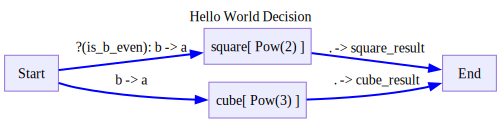

In [ ]:
d = NaiveDecision()
d.draw()

for trace in d.run({'a':1,'b':2}):
    pass
    # trace.pprint()
assert d.output == {'square_result':4}

for trace in d.run({'a':1,'b':3}):
    pass
    # trace.pprint()
assert d.output == {'cube_result':27}

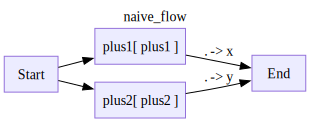

In [ ]:
d = NaiveFlow()
d.draw()

for trace in d.run(0):
    pass
    # trace.pprint()
assert d.output == {'x':1,'y':2}


In [ ]:
from stringdale.viz import draw_nx

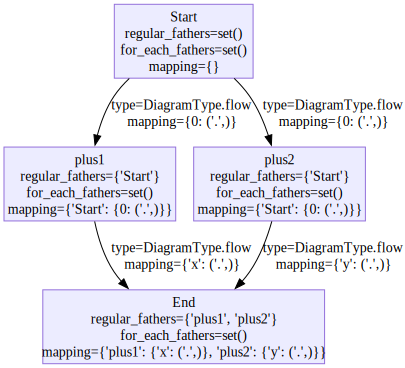

In [ ]:
draw_nx(d.graph)

# Serializing Diagram State

In [ ]:
#| export
@patch
def dump_state(self:Diagram):
    """Dump the state of the diagram and all its nodes into a json serializable dictionary
    """
    state_dict = dict()
    if self.state is not None:
        state_dict['state'] = self.state.model_dump()
    else:
        state_dict['state'] = None

    for attr in self.attrs_to_serialize:
        if hasattr(self,attr):
            state_dict[attr] = getattr(self,attr)

    if not self.anon:
        state_dict['node_state'] = dict()
        for node,func in self.funcs.items():
            if _is_attr_method(func,'dump_state'):
                state_dict['node_state'][node] = deepcopy(func.dump_state())
    return state_dict

@patch
def load_state(self:Diagram,state_dict):
    """Load the state of the diagram and all its nodes from a json serializable dictionary
    """
    self.reset()
    if state_dict.get('state',None) is not None:
        state_class = type(self.schema.state)
        self.state = state_class(**state_dict['state'])

    for attr in self.attrs_to_serialize:
        setattr(self,attr,state_dict[attr])

    if self.anon:
        return
    
    for node,state_obj in state_dict['node_state'].items():
        self.funcs[node].load_state(deepcopy(state_obj))
            

In [ ]:
#TODO make state save and read from flow diagram as well
# add explanation in complex diagrams that state can work for flow charts but we make no guarantee for order

# Export

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()